# Prototipo Qiskit: Grover de Umbral y Mínimo Dürr–Høyer (v2)

Objetivos:
- Detectar bombas sobre un umbral por variable (Grover con oráculo de umbral).
- Hallar la bomba más sana (mínimo, argmin) por variable con un bucle Dürr–Høyer robusto.

Notas:
- Variables normalizadas en [0, 1]; menor = más sano.
- Oráculos de valores embebidos (sin QRAM) para fines didácticos.
- Se usa un cálculo óptimo de iteraciones de Grover y varios intentos por ronda.
- Fijamos semilla y aumentamos shots para resultados más estables.

In [1]:
# Si lo necesitas: %pip install -U qiskit qiskit-aer
from math import ceil, log2, pi, sqrt, asin, floor
from collections import Counter
import random

from qiskit import QuantumCircuit, transpile
try:
    from qiskit_aer import Aer
except Exception:
    from qiskit import Aer

# Semilla para reproducibilidad en este cuaderno
random.seed(0)
print("Qiskit backend cargado:", Aer)

Qiskit backend cargado: AerProvider


In [2]:
def num_qubits_for_n(n_items: int) -> int:
    return max(1, ceil(log2(max(1, n_items))))

def index_to_bits(i: int, n_qubits: int):
    return [int(b) for b in format(i, f"0{n_qubits}b")]


In [3]:
def phase_oracle_gate(n_index: int, marked_indices):
    """
    Devuelve un Gate que aplica un flip de fase a |i> para i en marked_indices usando un ancilla en |->.
    El circuito espera n_index qubits de índice y 1 qubit ancilla al final.
    """
    qc = QuantumCircuit(n_index + 1, name="Oracle")
    for idx in marked_indices:
        bits = index_to_bits(idx, n_index)
        for qb, bit in enumerate(bits):
            if bit == 0:
                qc.x(qb)
        qc.mcx(list(range(n_index)), n_index)
        for qb, bit in enumerate(bits):
            if bit == 0:
                qc.x(qb)
    return qc.to_gate()

def diffuser_gate(n_index: int):
    qc = QuantumCircuit(n_index, name="Diffuser")
    qc.h(range(n_index))
    qc.x(range(n_index))
    if n_index == 1:
        qc.z(0)
    else:
        qc.h(n_index - 1)
        qc.mcx(list(range(n_index - 1)), n_index - 1)
        qc.h(n_index - 1)
    qc.x(range(n_index))
    qc.h(range(n_index))
    return qc.to_gate()

def optimal_grover_iterations(N: int, M: int) -> int:
    if M <= 0 or M > N:
        return 1
    theta = asin(sqrt(M / N))
    k = floor(pi / (4 * theta) - 0.5)
    return max(1, k)

def run_grover_threshold(marked_indices, n_items: int, iterations: int = 1, shots: int = 4096):
    n_index = num_qubits_for_n(n_items)
    qc = QuantumCircuit(n_index + 1, n_index, name="GroverThreshold")
    qc.h(range(n_index))
    qc.x(n_index)
    qc.h(n_index)
    oracle = phase_oracle_gate(n_index, marked_indices)
    diffuser = diffuser_gate(n_index)
    for _ in range(iterations):
        qc.append(oracle, list(range(n_index + 1)))
        qc.append(diffuser, list(range(n_index)))
    qc.measure(list(range(n_index)), list(range(n_index)))
    backend = Aer.get_backend("qasm_simulator")
    tqc = transpile(qc, backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()
    return counts, qc


## Datos de ejemplo (sintético)
- Valores bajos son equipos sanos.
- Demostramos búsqueda de umbral (τ = 0.8) y mínimo.


In [4]:
pump_ids = [f"P{i:03d}" for i in range(8)]
time_of_use  = [0.10, 0.52, 0.33, 0.01, 0.72, 0.64, 0.28, 0.41]
max_current  = [0.21, 0.18, 0.11, 0.09, 0.85, 0.67, 0.44, 0.32]
vibration    = [0.03, 0.14, 0.59, 0.20, 0.22, 0.47, 0.18, 0.35]
N = len(pump_ids)
tau = 0.8


## Grover de umbral (candidatos a mantenimiento)


In [5]:
values = max_current
marked = [i for i, v in enumerate(values) if v >= tau]
M = len(marked)
print("Índices marcados (v >= tau):", marked)
if M == 0:
    print("No hay bombas sobre el umbral.")
else:
    k = optimal_grover_iterations(N, M)
    counts, qc = run_grover_threshold(marked, N, iterations=k, shots=4096)
    print("Iteraciones Grover:", k)
    print("Resultados principales:")
    for bitstring, c in Counter(counts).most_common(8):
        idx = int(bitstring, 2)
        print(bitstring, "-> índice", idx, pump_ids[idx], "conteo", c)


Índices marcados (v >= tau): [4]
Iteraciones Grover: 1
Resultados principales:
001 -> índice 1 P001 conteo 3217
111 -> índice 7 P007 conteo 150
101 -> índice 5 P005 conteo 140
110 -> índice 6 P006 conteo 134
000 -> índice 0 P000 conteo 128
010 -> índice 2 P002 conteo 123
100 -> índice 4 P004 conteo 110
011 -> índice 3 P003 conteo 94


## Mínimo Dürr–Høyer robusto (bomba más sana)


In [16]:
def dh_min_index(values, shots=4096, max_rounds=8, tries_per_round=3):
    N = len(values)
    current = random.randrange(N)
    current_val = values[current]
    history = [(current, current_val)]
    for _ in range(max_rounds):
        marked = [j for j, v in enumerate(values) if v < current_val]
        if not marked:
            break
        M = len(marked)
        improved = False
        for _ in range(tries_per_round):
            k = optimal_grover_iterations(N, M)
            counts, _ = run_grover_threshold(marked, N, iterations=k, shots=shots)
            candidates = [(int(bs, 2), c) for bs, c in counts.items()]
            candidates.sort(key=lambda x: x[1], reverse=True)
            cand_idx = candidates[0][0]
            cand_val = values[cand_idx]
            history.append((cand_idx, cand_val))
            if cand_val < current_val:
                current, current_val = cand_idx, cand_val
                improved = True
                break
        if not improved:
            k_max = optimal_grover_iterations(N, max(1, M))
            k_rand = random.randint(0, max(1, k_max))
            counts, _ = run_grover_threshold(marked, N, iterations=max(1, k_rand), shots=shots)
            candidates = [(int(bs, 2), c) for bs, c in counts.items()]
            candidates.sort(key=lambda x: x[1], reverse=True)
            cand_idx = candidates[0][0]
            cand_val = values[cand_idx]
            history.append((cand_idx, cand_val))
            if cand_val < current_val:
                current, current_val = cand_idx, cand_val
            else:
                break
    return current, history

# Ejecutar prueba de mínimo sobre time_of_use
values = time_of_use
idx_q, hist = dh_min_index(values, shots=4096, max_rounds=6)
idx_classico = min(range(N), key=lambda i: values[i])
print("Índice cuántico (argmin):", idx_q, pump_ids[idx_q], "valor=", values[idx_q])
print("Índice clásico (argmin):", idx_classico, pump_ids[idx_classico], "valor=", values[idx_classico])
print("¿Coinciden?", "Sí" if idx_q == idx_classico else "No")
print("Historia (índice, valor):", hist)


Índice cuántico (argmin): 3 P003 valor= 0.01
Índice clásico (argmin): 3 P003 valor= 0.01
¿Coinciden? Sí
Historia (índice, valor): [(7, 0.41), (2, 0.33), (3, 0.01)]


Clásico (argmin): idx=3 (P003) valor=0.010
Ensayos: 200 | Coinciden: 41 | No coinciden: 159 | Acierto: 20.5%


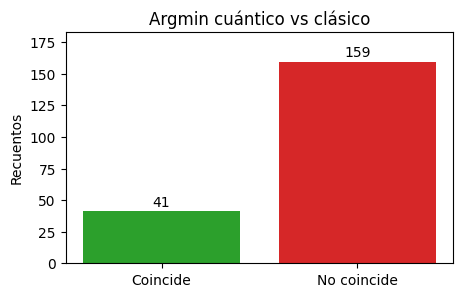

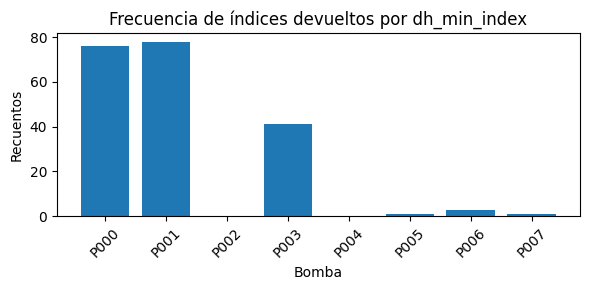

In [20]:
# Iteraciones para estimar tasa de aciertos del argmin cuántico
import random
import matplotlib.pyplot as plt
from collections import Counter

# Parámetros
values = time_of_use  # cambia a max_current, vibration, etc. si quieres
trials = 200
shots = 4096
max_rounds = 6
tries_per_round = 3  # coherente con dh_min_index

# Índice clásico de referencia
N = len(values)
idx_classico = min(range(N), key=lambda i: values[i])

# Ejecutar múltiples veces
hits = 0
misses = 0
q_indices = []

# Opcional: fija semilla para reproducibilidad de este bloque
random.seed(1)

for _ in range(trials):
    idx_q, _ = dh_min_index(values, shots=shots, max_rounds=max_rounds, tries_per_round=tries_per_round)
    q_indices.append(idx_q)
    if idx_q == idx_classico:
        hits += 1
    else:
        misses += 1

print(f"Clásico (argmin): idx={idx_classico} ({pump_ids[idx_classico]}) valor={values[idx_classico]:.3f}")
print(f"Ensayos: {trials} | Coinciden: {hits} | No coinciden: {misses} | Acierto: {100*hits/trials:.1f}%")

# Histograma de coincidencias vs no
plt.figure(figsize=(5,3))
plt.bar(['Coincide','No coincide'], [hits, misses], color=['tab:green','tab:red'])
plt.title('Argmin cuántico vs clásico')
plt.ylabel('Recuentos')
for x, y in zip(['Coincide','No coincide'], [hits, misses]):
    plt.text(x, y + max(1, trials*0.01), f"{y}", ha='center', va='bottom')
plt.ylim(0, max(hits, misses)*1.15 if trials>0 else 1)
plt.show()

# (Opcional) Distribución de índices cuánticos devueltos
plt.figure(figsize=(6,3))
counts = Counter(q_indices)
plt.bar([pump_ids[i] for i in range(N)], [counts.get(i,0) for i in range(N)], color='tab:blue')
plt.title('Frecuencia de índices devueltos por dh_min_index')
plt.ylabel('Recuentos')
plt.xlabel('Bomba')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()